## Import libraries

In [685]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import mapping, Polygon, Point
import fiona
from typing import List, Tuple, Dict
import warnings

warnings.filterwarnings("ignore", module="matplotlib")


def rgb_to_hex(rgb: [int]) -> str:
    return "#" + '%02x%02x%02x' % rgb


def show(img: List[List]):
    print(str(img))
    cv2.imshow("", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def show_in_grid(images: List[List[List]]):
    max_width = 3
    if len(images) == 1:
        _, axis = plt.subplots(1, 1, figsize=[15, 15])
        axis.imshow(images[0], cmap="gray")
    elif len(images) < max_width:
        _, axis = plt.subplots(1, len(images), figsize=[15, 15])
        for i in range(len(images)):
            axis[i].imshow(images[i], cmap="gray")
    else:
        _, axis = plt.subplots(int(np.ceil(len(images) / max_width)), max_width, figsize=[20, 20])
        for i in range(len(images)):
            axis[i // max_width][i % max_width].imshow(images[i], cmap="gray")


- cv2: library for computer vision
- numpy: library for arrays in python
- matplotlib.pyplot: plotting library
- shapely: geometry library
- fiona: core of gdal-library

## Load and setup an image
Loads the image then converts it to gray-space where each pixel only holds a brightness value.
The resulting map is shown below.
The image is initialized in three variables:
1. img: in BGR-Space
2. grey: in grey-scale
3. hsv: in HSV-Space
4. mask: in 0,1

<Figure size 720x720 with 0 Axes>

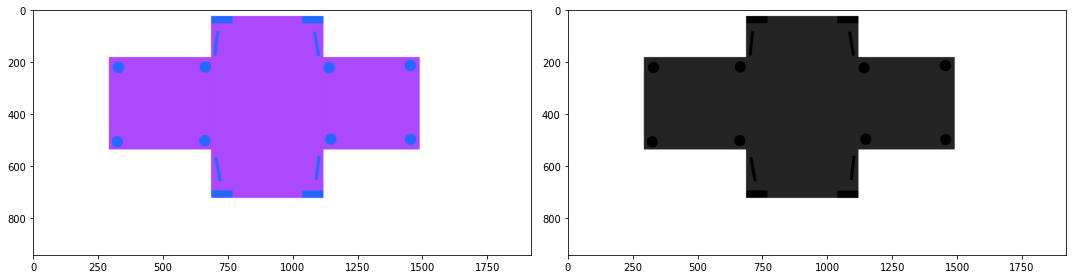

In [686]:
imgName = "testImages/testimage5.png"
img = cv2.imread(imgName, cv2.IMREAD_UNCHANGED)
## convert to gray
gray = cv2.imread(imgName, 0)
## convert to hsv color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
## create mask
mask = cv2.inRange(hsv, (138, 2, 0), (179, 255, 255))

plt.figure(figsize=[10, 10])
_, axis = plt.subplots(1, 2, figsize=[15, 15])
axis[0].imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
axis[1].imshow(gray, cmap="gray")
## axis[2].imshow(cv2.bitwise_not(mask), cmap="gray")

## Extract Shapes
### Canny-Edge detection
At first we extract edges in the grayscaled image, by using cv2.Canny(). Edges are rated from 0 to 255 based on their contrast (0 weak edge -> 255 strong edge)
The two threshold parameters define three intervals:
1. every edge with a lower rating than the first threshold is not used
2. every edge with a higher rating than the second threshold is used
3. every edge with a higher rating than the first and a lower rating than the second threshold is used if and only if it is connected to an edge with a higher rating than the second threshold
### Contour extraction
Afterwards the contour extraction is given the canny result as input.
The used algorithm is described in [this paper](https://www.sciencedirect.com/science/article/abs/pii/0734189X85900167)


There are 13 contours in total


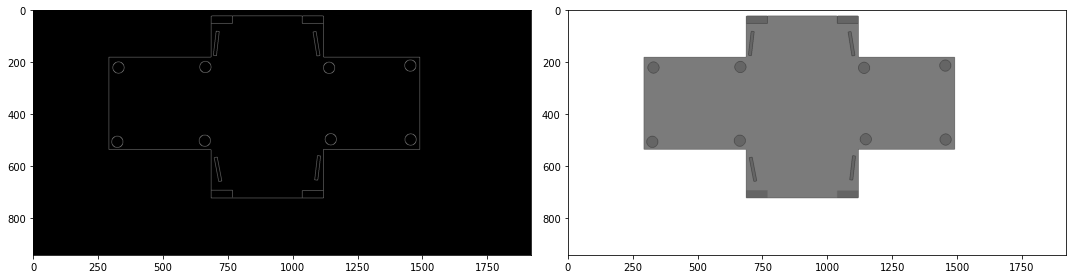

In [687]:
# extract contours
def extract_contours(image: List[List]) -> Tuple[List[List[List]]]:
    imageCp = np.copy(image)
    edges = cv2.Canny(imageCp, 20, 100, apertureSize=3)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    to_be_removed = []
    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1:
            to_be_removed.append(i)
            continue

    contours = np.delete(contours, to_be_removed)

    print("There are " + str(len(contours)) + " contours in total")

    cv2.drawContours(imageCp, contours, -1, (0, 255, 0), 1)

    _, axis = plt.subplots(1, 2, figsize=[15, 15])
    axis[0].imshow(edges, cmap="gray")
    axis[1].imshow(imageCp, cmap="gray")
    return contours


contours = extract_contours(gray)

## Convert to simple Shapes if possible
The resulting polygons can then be migrated to Shapely polygons.
In a second step these polygons can be simplified by the [Douglas-Peucker algorithm](https://de.wikipedia.org/wiki/Douglas-Peucker-Algorithmus)
Assuming all Shapes are either rectangles, circles or something else, calculate the enclosing circle and rectangles.
If the area of the enclosing circle/rectangle is close to the area of the original, replace the original by the circle/rectangle.

1 polygons
4 rectangles
8 circles


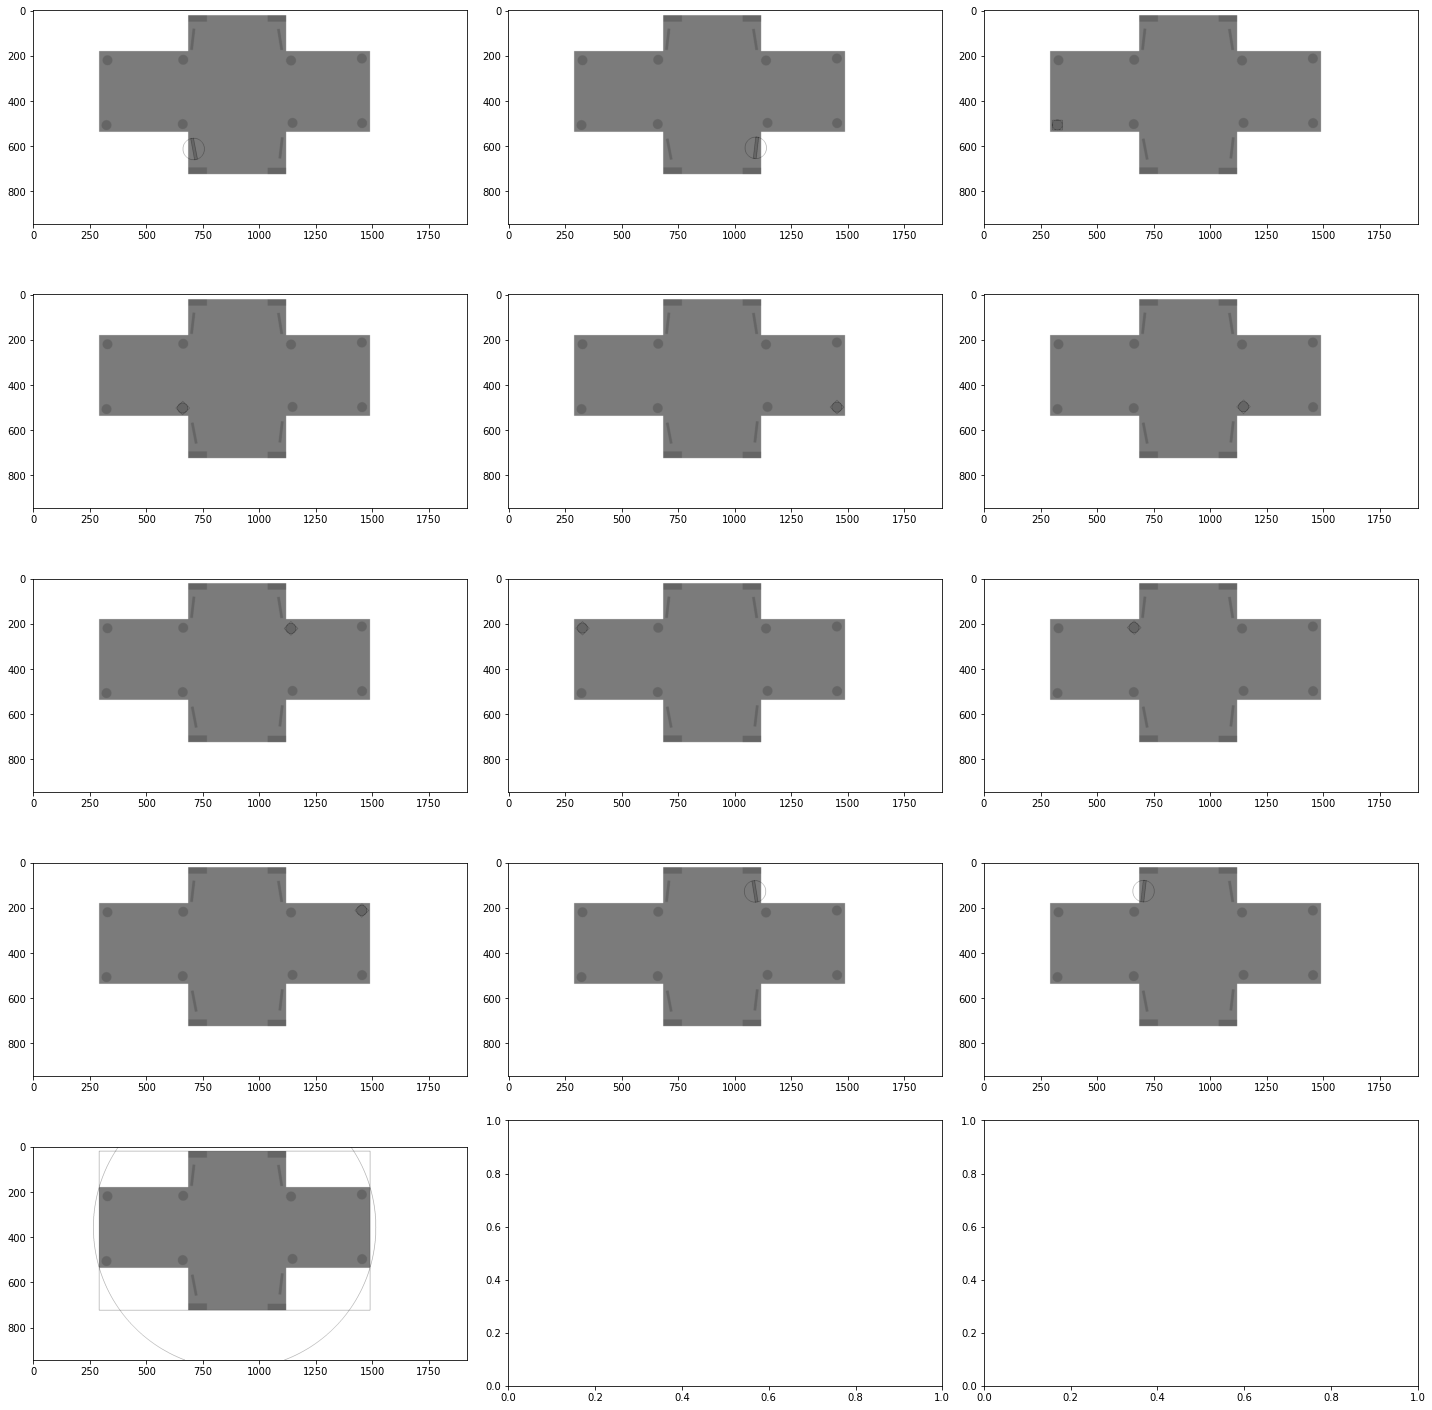

In [688]:
def to_shapes(contours) -> Tuple[List[Polygon], List[Polygon], List]:
    polygons = []
    rectangles = []
    circles = []
    images = []
    for i in range(len(contours)):
        minRect = cv2.minAreaRect(contours[i])
        (x, y), r = cv2.minEnclosingCircle(contours[i])
        box = cv2.boxPoints(minRect)

        original = Polygon(np.squeeze(contours[i])).simplify(1, preserve_topology=False)
        originalArea = original.area

        if (originalArea / original.minimum_rotated_rectangle.area) > 0.9:
            rect = Polygon(box)
            rectangles.append(rect)
        elif (originalArea / (math.pi * math.pow(r, 2))) > 0.9:
            circle = Point(x, y).buffer(r)
            circles.append(circle)
        else:
            polygons.append(original)

        grayCp = np.copy(gray)
        cv2.circle(grayCp, (int(x), int(y)), int(np.ceil(r)), (0, 0, 255), 1)
        cv2.drawContours(grayCp, [np.int0(box)], 0, (0, 0, 255), 1)
        images.append(grayCp)

    show_in_grid(images)
    return polygons, rectangles, circles


polygons, rects, circles = to_shapes(contours)
print(str(len(polygons)) + " polygons")
print(str(len(rects)) + " rectangles")
print(str(len(circles)) + " circles")

## Direction correction
The resulting polygons contain edges that are skew meaning that their direction varies slightly from common directions.
These skew directions shall now be corrected. Therefore, in the first step common directions in an edge's neighborhood are identified.

#### Measure common directions
For each direction calculate the total distance of lines that go in this direction.
Results are stored in a sorted dict.

In [689]:
def build_direction_dict(polygons: List[Polygon], rectangles: List[Polygon], tolerance: float) -> Dict[List, int]:
    ## measure distances per direction
    resulting_dict: Dict[List, int] = {}
    for polygon in polygons + rectangles:
        xs, ys = polygon.exterior.coords.xy
        n = len(xs)
        for i in range(n):
            v = np.array([xs[(i + 1) % n] - xs[i], ys[(i + 1) % n] - ys[i]])
            norm = np.linalg.norm(v)
            if norm == 0:
                continue
            key = int(round(math.acos(v[0] / norm) * 180 / math.pi, 0)) % 360
            if v[1] < 0:
                key = (360 - key) % 360
            if key not in resulting_dict:
                resulting_dict[key] = 0
            resulting_dict[key] += norm

    ## sort directions descending
    l = list(resulting_dict.items())
    l.sort(reverse=True, key=lambda dictItem: dictItem[1])

    ## merge directions close to each other
    to_be_removed = []
    for i in range(len(l)):
        for j in range(i):
            if abs(l[i][0] - l[j][0]) < tolerance:
                to_be_removed.append(i)
                new_entry = (l[j][0], l[j][1] + l[i][1])
                l[j] = new_entry
                l.sort(reverse=True, key=lambda dictItem: dictItem[1])
                break

    for i in reversed(to_be_removed):
        del l[i]

    threshold = 0.05 * l[0][1]
    l = filter(lambda el: el[1] > threshold, l)

    ## return list as dict
    resulting_dict = {}
    for entry in l:
        resulting_dict[entry[0]] = int(entry[1])

    return resulting_dict


dict = build_direction_dict(polygons, rects, 5)
print("Dict: " + str(dict))

Dict: {0: 1192, 180: 1179, 270: 723, 90: 721, 277: 189, 97: 189, 79: 189, 259: 189}


### Snap edges to directions
#### Select edges to snap
Given an angle-tolerance t. Edges are snapped to the most common direction based on the differences in the directions and the edge's length.
Short edges allow a greater angle-difference while still being snapped. The "likelihood" `s(e, a)` of a vector `e` to be snapped onto direction `a` is:
`s(e, a) = 1 /(|e.angle - a| * ||e||)^c` where `e.angel = arccos(e.x / ||e||)` and `c` is an acceptance parameter.
For edges that already go in the same direction as `a`, this step is skipped. The illustrations below show `s(e, 0)` for `c = 0.3` in `[-5, 5]x[-5, 5]`

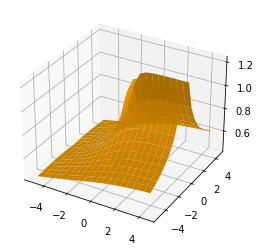

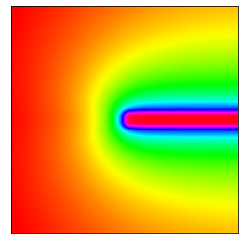

In [690]:
def show_f():
    def f(xs, ys):
        return np.array([1 / np.power(np.abs(np.arccos(i / np.sqrt(np.power(i, 2) + np.power(j, 2))) - a) * np.sqrt(
            np.power(i, 2) + np.power(j, 2)), c) for i in xs for j in ys])

    x = np.arange(-5, 5, 0.5)
    y = np.arange(-5, 5, 0.5)
    x, y = np.meshgrid(x, y)
    a = 0
    c = 0.3
    z = 1 / np.power(
        np.abs(np.arccos(x / np.sqrt(np.power(x, 2) + np.power(y, 2))) - a) * np.sqrt(np.power(x, 2) + np.power(y, 2)),
        c)
    # creating an empty figure for plotting
    fig = plt.figure()

    ax = fig.gca(projection='3d')
    # Creating a wireframe plot with the x,y and
    # z-coordinates respectively along with the
    # color as red
    ax.plot_surface(x, y, z, color="orange")
    #showing the above plot
    plt.show()

    x = y = np.linspace(-5, 5, 30)
    z = f(x, y)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.imshow(np.rot90(z.reshape(30, 30)), cmap="hsv", interpolation="bilinear")

    plt.show()


show_f()

#### Snap edges


## Export to File
There are svg and shp files types that describe vectorized images

In [691]:
def export_contours_to_svg(contours, file_name):
    assert (str.endswith(file_name, '.svg'))
    f = open(file_name, 'w+')
    f.write(
        '<svg width="' + str(img.shape[1]) + '" height="' + str(img.shape[0]) + '" xmlns="http://www.w3.org/2000/svg">')
    for c in contours:
        f.write('<path d="M')

        for i in range(len(c)):
            x, y = c[i][0]
            f.write(str(x) + ' ' + str(y) + ' ')

        x, y = c[0, 0]
        b, g, r = img[y, x]
        f.write('" fill="' + str(rgb_to_hex((r, g, b))) + '"')
        f.write('/>')

    f.write('</svg>')
    f.close()

In [692]:
def export_to_shp(polygons: List[Polygon], file_name: str):
    assert (str.endswith(file_name, '.shp'))
    # Here's an example Shapely geometry
    for poly in polygons:
        # Define a polygon feature geometry with one attribute
        schema = {
            'geometry': 'Polygon',
            'properties': {'id': 'int'},
        }

        # Write a new Shapefile
        with fiona.open(file_name, 'w', 'ESRI Shapefile', schema) as c:
            ## If there are multiple geometries, put the "for" loop here
            c.write({
                'geometry': mapping(poly),
                'properties': {'id': 123},
            })


def export_to_svg(polygons: List[Polygon], file_name: str):
    assert (str.endswith(file_name, '.svg'))
    # Here's an example Shapely geometry
    f = open(file_name, 'w+')
    f.write(
        '<svg width="' + str(img.shape[1]) + '" height="' + str(img.shape[0]) + '" xmlns="http://www.w3.org/2000/svg">')
    for poly in polygons:
        f.write('<path d="M')
        xs, ys = poly.exterior.coords.xy
        for i in range(len(xs)):
            f.write(str(xs[i]) + ' ' + str(ys[i]) + ' ')

        """b, g, r = img[ys[i], xs[i]]
        f.write('" fill="' + str(rgb_to_hex((r, g, b))) + '"')"""
        f.write('"/>')

    f.write('</svg>')
    f.close()

export_to_svg(polygons + rects + circles, "polygons.svg")